# Лабораторна робота №4
## Баштового Івана
## Варіант № 14
# Тема :
## Побудова моделi згорткових нейронних мереж для класифiкацiї зображень в TensorFlow

# Мета роботи:

## • Навчитися створювати моделi згорткових нейронних мереж за допомогою бi-блiотеки TensorFlow та API Keras.

## • Використати згорткову нейронну мережу для класифiкацiї чорно-бiлих та ко-льорових зображень.

## • Порiвняти результати з результатами на основi моделi MLP.

## • Для представлення результатiв використати TensorBoard.

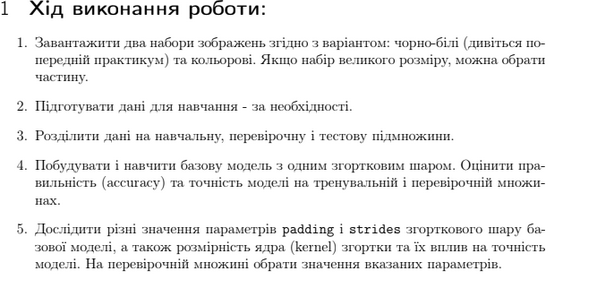

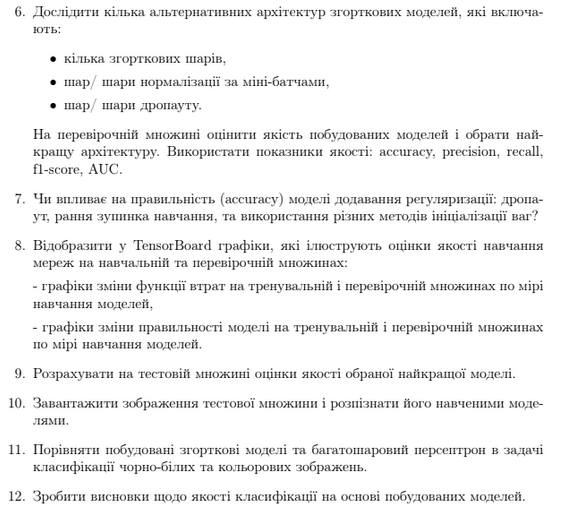

### Варіант 14 -  5 Flower Types Classification Dataset, kaggle.com

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import itertools
from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Preprocessing


In [3]:
data_dir = "flower_images"

filepaths = []
labels = []

# List subdirectories (folds) excluding any non-directory files
folds = [fold for fold in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, fold))]

for fold in folds:
    foldpaths = os.path.join(data_dir, fold)
    filelists = os.listdir(foldpaths)
    
    for file in filelists:
        if file != '.DS_Store':  # Skip .DS_Store files
            filepath= os.path.join(foldpaths, file)
        
            filepaths.append(filepath)
            labels.append(fold)
        
Fseries = pd.Series(filepaths, name='Filepath')
Lseries = pd.Series(labels, name='Label')

df = pd.concat([Fseries, Lseries], axis=1)
df.head()

,Filepath,Label
0,flower_images/Lotus/16905dde87.jpg,Lotus
1,flower_images/Lotus/839f7d1a14.jpg,Lotus
2,flower_images/Lotus/6acf5327ad.jpg,Lotus
3,flower_images/Lotus/327793cdf0.jpg,Lotus
4,flower_images/Lotus/c8e4698aa0.jpg,Lotus


<Axes: xlabel='Label', ylabel='Count'>

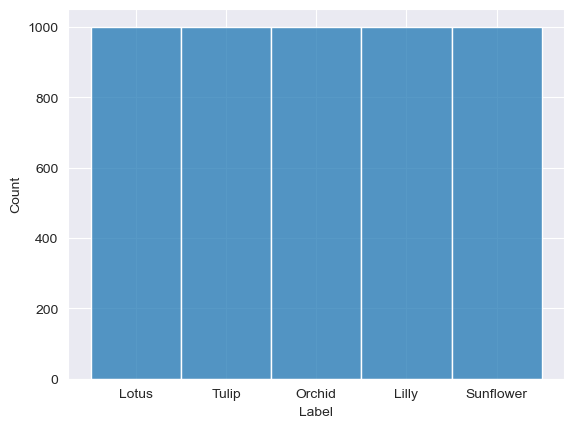

In [4]:
sns.histplot(df["Label"])

In [5]:
# Function to reduce the number of samples by half while keeping class balance
def reduce_samples_by_half(df):
    unique_labels = df['Label'].unique()
    reduced_df = pd.DataFrame(columns=['Filepath', 'Label'])

    for label in unique_labels:
        temp_df = df[df['Label'] == label]
        reduced_temp_df = temp_df.sample(frac=0.5)
        reduced_df = pd.concat([reduced_df, reduced_temp_df], axis=0)

    return reduced_df.reset_index(drop=True)


In [6]:
reduced_df = reduce_samples_by_half(df)
reduced_df.head()

,Filepath,Label
0,flower_images/Lotus/f1a574574e.jpg,Lotus
1,flower_images/Lotus/573b84b59a.jpg,Lotus
2,flower_images/Lotus/9f21409118.jpg,Lotus
3,flower_images/Lotus/61d416b1bf.jpg,Lotus
4,flower_images/Lotus/5ebfaaaf03.jpg,Lotus


<Axes: xlabel='Label', ylabel='Count'>

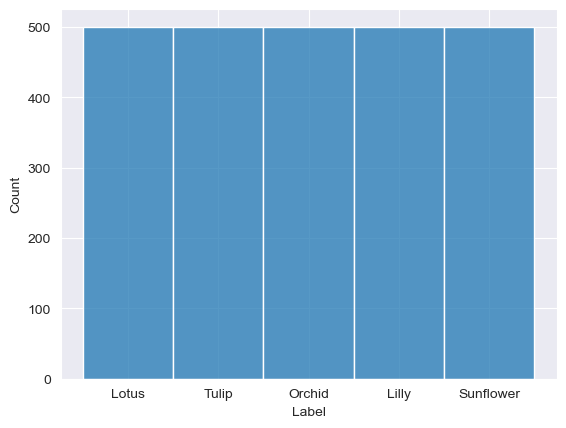

In [7]:
sns.histplot(reduced_df["Label"])

## Split data into train, valid & test


In [8]:
train_df, dummy_df = train_test_split(df, test_size=0.2, shuffle= True, random_state= 42,
                                     stratify= df['Label'])

valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle= True, random_state= 42,
                                    stratify= dummy_df['Label'])

In [10]:
print(f"Train shape = {train_df.shape}")
print(f"Valid shape = {valid_df.shape}")
print(f"Test shape = {test_df.shape}")

Train shape = (4000, 2)
Valid shape = (500, 2)
Test shape = (500, 2)


## Create image data generator


In [11]:
batch_size = 16
image_size = (224, 224)

# # Data augmentation for training data
# train_generator = ImageDataGenerator(
#     rescale=1.0/255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# No Data augmentation for training data
train_generator = ImageDataGenerator(
    rescale=1.0/255
)

# Only rescaling for validation and test data
validation_generator = ImageDataGenerator(rescale=1.0/255)
test_generator = ImageDataGenerator(rescale=1.0/255)

# Flow from DataFrame for grayscale images without data augmentation
train_generator = train_generator.flow_from_dataframe(
    train_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='grayscale',  
    batch_size=batch_size, 
    target_size=image_size
)

validation_generator = validation_generator.flow_from_dataframe(
    valid_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='grayscale',  
    batch_size=batch_size, 
    target_size=image_size
)

test_generator = test_generator.flow_from_dataframe(
    test_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='grayscale',  
    batch_size=batch_size, 
    target_size=image_size
)


Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


## Show sample from train data


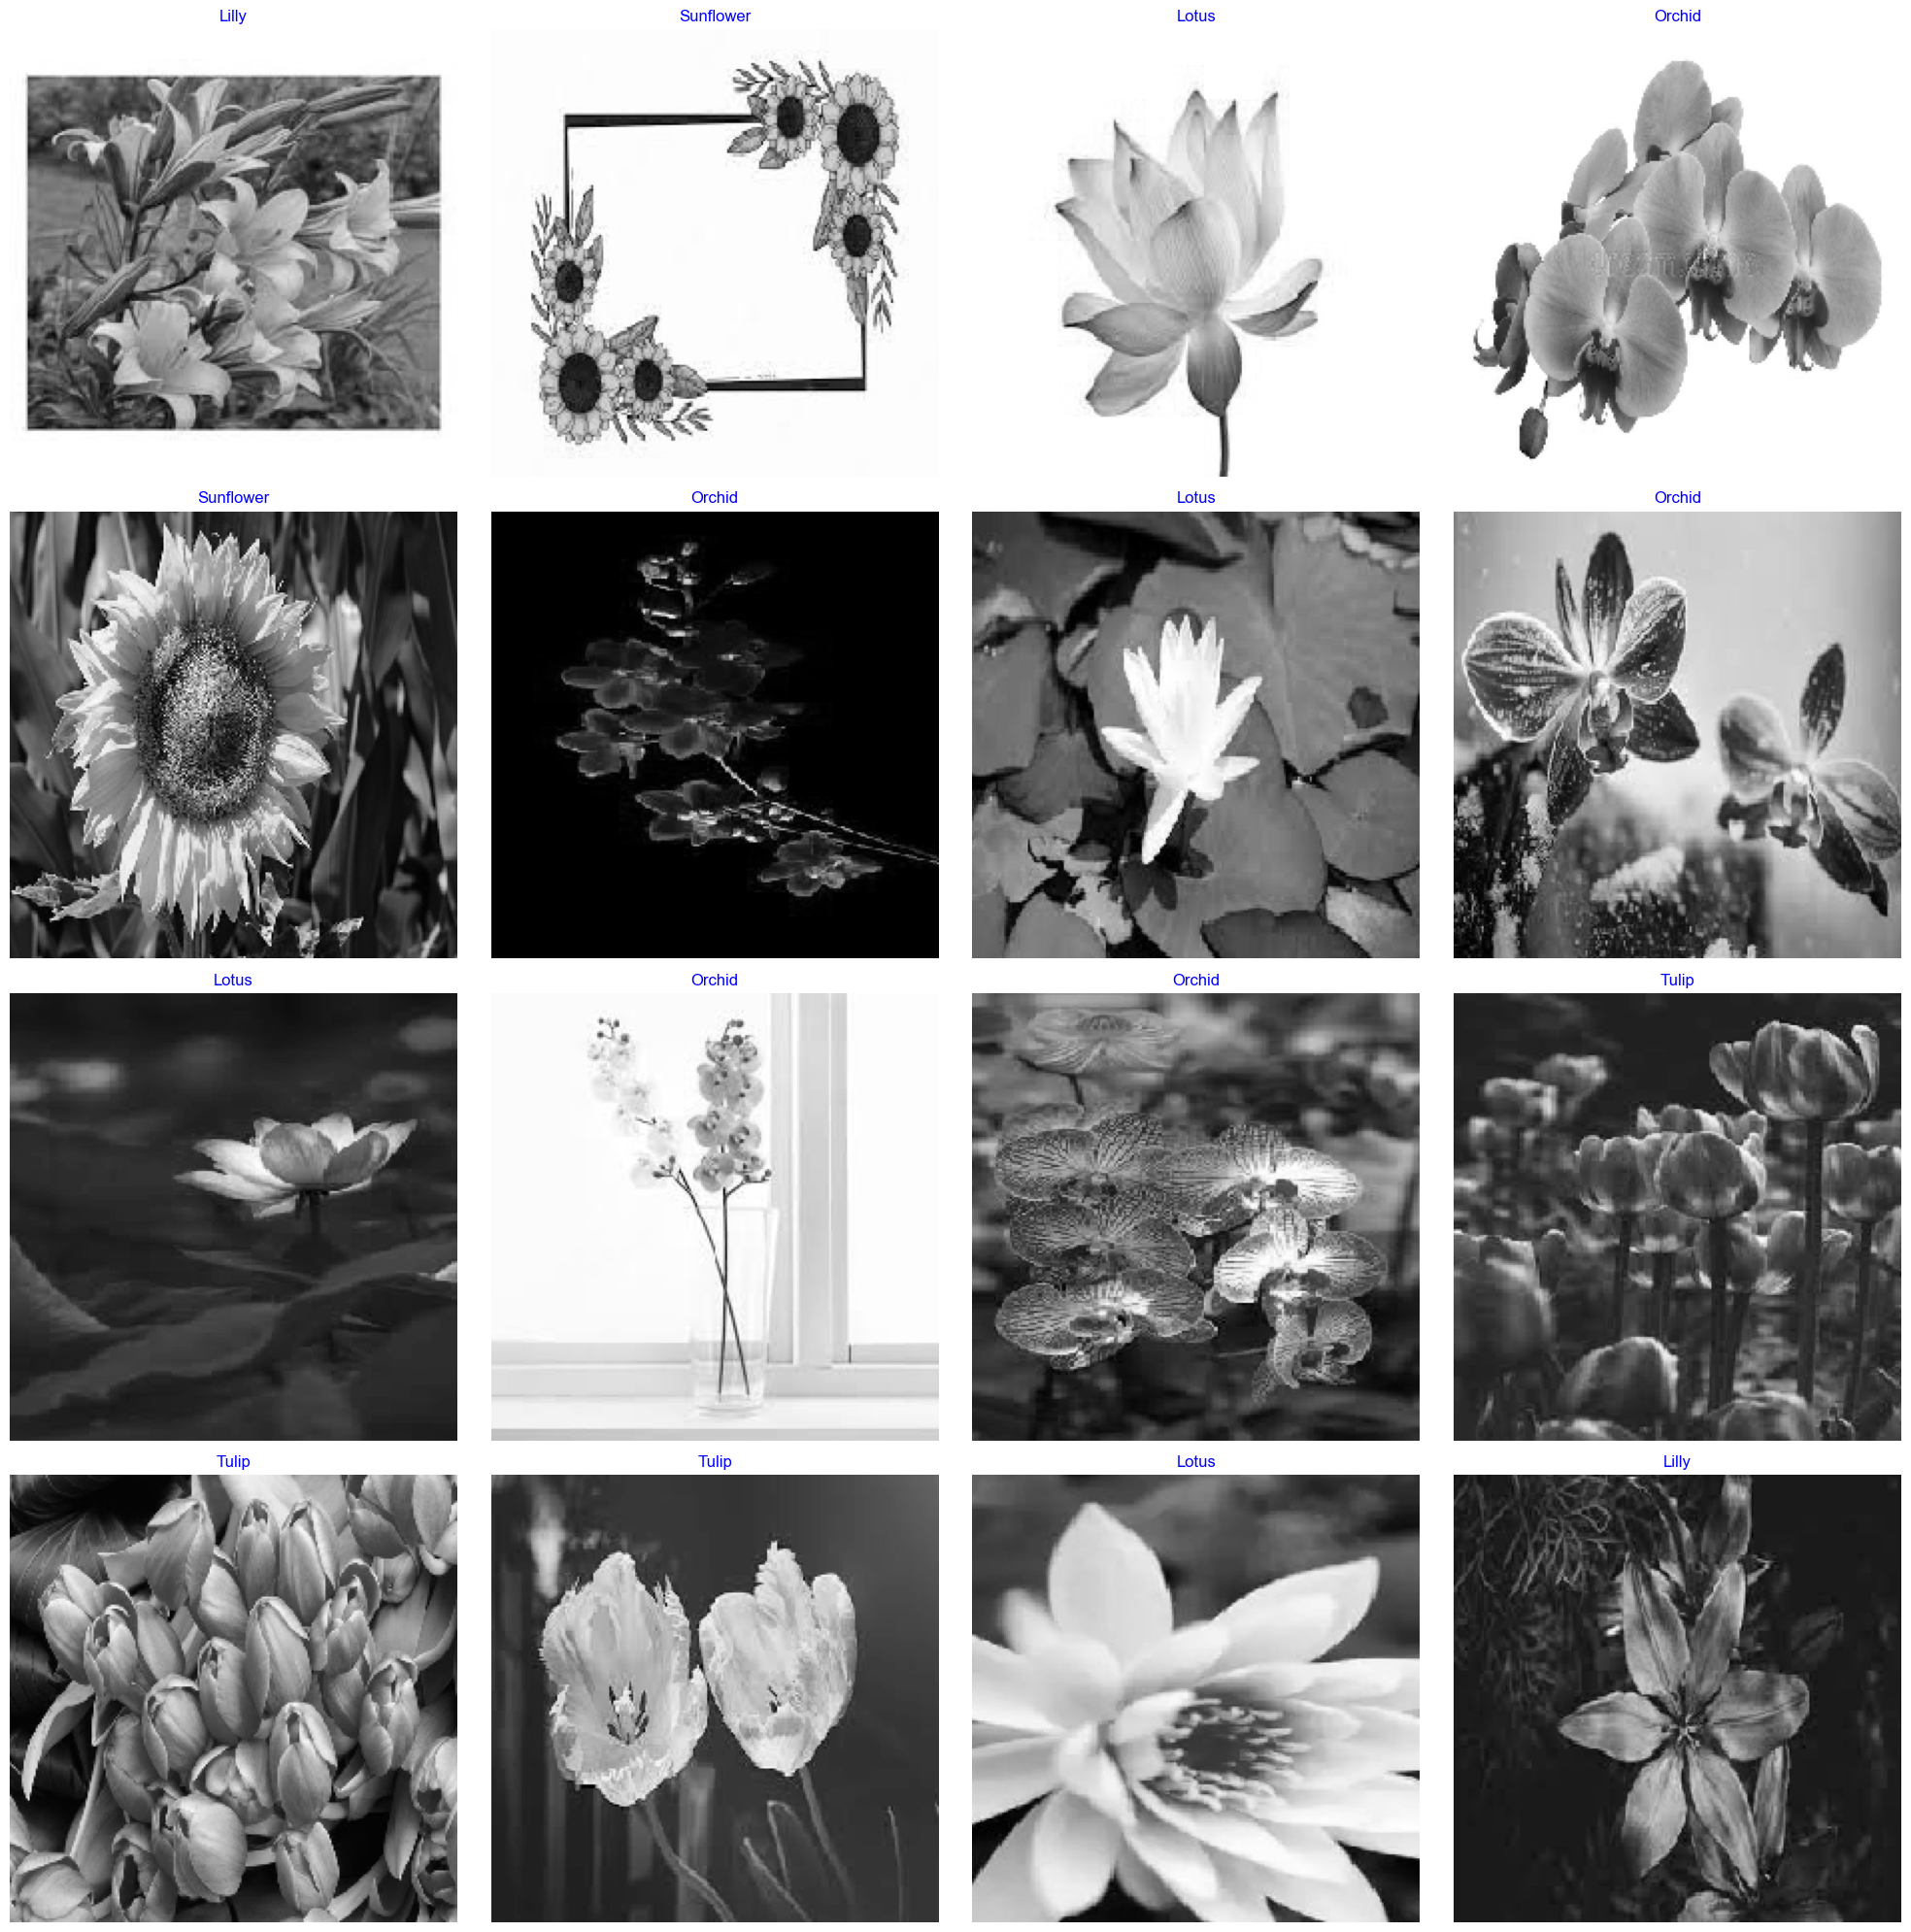

In [39]:
gen_dict = train_generator.class_indices
classes_name = list(gen_dict.keys())

# Fetch a batch of images and labels
images, labels = next(train_generator)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i].squeeze()  
    plt.imshow(image, cmap='gray') 
    index = np.argmax(labels[i]) 
    class_name = classes_name[index]  
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')


plt.tight_layout()
plt.show()

## Build a Basic CNN Model
#### Let's start with a basic model with a single convolutional layer:

In [17]:
basic_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(5, activation='softmax')  
])

basic_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_basic_cnn = basic_cnn.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
  1/250 [..............................] - ETA: 1:02 - loss: 1.6604 - accuracy: 0.0625

2024-05-18 19:05:32.500719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.8652 - accuracy: 0.4278

2024-05-18 19:05:46.322424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 16s 63ms/step - loss: 1.8652 - accuracy: 0.4278 - val_loss: 1.2062 - val_accuracy: 0.5780
Epoch 2/10
250/250 [==============================] - 15s 61ms/step - loss: 0.6136 - accuracy: 0.8205 - val_loss: 0.9126 - val_accuracy: 0.6960
Epoch 3/10
250/250 [==============================] - 15s 60ms/step - loss: 0.2318 - accuracy: 0.9520 - val_loss: 0.8393 - val_accuracy: 0.7420
Epoch 4/10
250/250 [==============================] - 15s 60ms/step - loss: 0.0928 - accuracy: 0.9885 - val_loss: 0.8754 - val_accuracy: 0.7380
Epoch 5/10
250/250 [==============================] - 15s 61ms/step - loss: 0.0511 - accuracy: 0.9948 - val_loss: 0.9102 - val_accuracy: 0.7520
Epoch 6/10
250/250 [==============================] - 15s 61ms/step - loss: 0.0514 - accuracy: 0.9953 - val_loss: 0.9160 - val_accuracy: 0.7540
Epoch 7/10
250/250 [==============================] - 15s 61ms/step - loss: 0.0468 - accuracy: 0.9938 - val_loss: 0.9671 - val_accuracy: 0.7380
Epo

We see that our model  overfits, therefore, we can assume that adding dropout may helps us get better result on validation set 

## Investigate Hyperparameters
#### Explore different values for padding, strides, and kernel_size:

In [18]:
# Define a function to create models with different parameters
def create_model(kernel_size, strides, padding):
    model = Sequential([
        Conv2D(32, kernel_size, strides=strides, padding=padding, activation='relu', input_shape=(224, 224, 1)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(5, activation='softmax') 
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train models with different parameters
kernel_sizes = [(3, 3), (5, 5), (7, 7)]
strides = [(1, 1), (2, 2), (3, 3)]
paddings = ['valid', 'same']

for kernel_size in kernel_sizes:
    for stride in strides:
        for padding in paddings:
            model = create_model(kernel_size, stride, padding)
            history = model.fit(train_generator, epochs=3, 
                                validation_data=validation_generator, 
                                verbose=2)
            print(f'Kernel size: {kernel_size}, Stride: {stride}, Padding: {padding}')
            print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')

Epoch 1/3


2024-05-18 19:08:16.193414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:08:29.816920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 16s - loss: 2.2381 - accuracy: 0.4025 - val_loss: 1.2120 - val_accuracy: 0.5400 - 16s/epoch - 63ms/step
Epoch 2/3
250/250 - 16s - loss: 0.6549 - accuracy: 0.8108 - val_loss: 0.9722 - val_accuracy: 0.6840 - 16s/epoch - 63ms/step
Epoch 3/3
250/250 - 15s - loss: 0.2357 - accuracy: 0.9518 - val_loss: 0.8790 - val_accuracy: 0.7460 - 15s/epoch - 61ms/step
Kernel size: (3, 3), Stride: (1, 1), Padding: valid
Validation accuracy: 0.7460000514984131
Epoch 1/3


2024-05-18 19:09:02.943158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:09:16.894618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 16s - loss: 2.2872 - accuracy: 0.3770 - val_loss: 1.2397 - val_accuracy: 0.5400 - 16s/epoch - 64ms/step
Epoch 2/3
250/250 - 16s - loss: 0.7371 - accuracy: 0.7595 - val_loss: 1.0051 - val_accuracy: 0.6320 - 16s/epoch - 63ms/step
Epoch 3/3
250/250 - 15s - loss: 0.2898 - accuracy: 0.9288 - val_loss: 0.8902 - val_accuracy: 0.7200 - 15s/epoch - 60ms/step
Kernel size: (3, 3), Stride: (1, 1), Padding: same
Validation accuracy: 0.7200000286102295
Epoch 1/3


2024-05-18 19:09:49.712153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:10:03.132320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5644 - accuracy: 0.3738 - val_loss: 1.3413 - val_accuracy: 0.4320 - 15s/epoch - 62ms/step
Epoch 2/3
250/250 - 15s - loss: 0.8925 - accuracy: 0.7008 - val_loss: 1.0898 - val_accuracy: 0.5960 - 15s/epoch - 61ms/step
Epoch 3/3
250/250 - 15s - loss: 0.4982 - accuracy: 0.8698 - val_loss: 0.9585 - val_accuracy: 0.6680 - 15s/epoch - 59ms/step
Kernel size: (3, 3), Stride: (2, 2), Padding: valid
Validation accuracy: 0.6680000424385071
Epoch 1/3


2024-05-18 19:10:35.281006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:10:48.731839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5007 - accuracy: 0.3908 - val_loss: 1.3027 - val_accuracy: 0.4860 - 15s/epoch - 61ms/step
Epoch 2/3
250/250 - 14s - loss: 0.8790 - accuracy: 0.7100 - val_loss: 1.1772 - val_accuracy: 0.5660 - 14s/epoch - 56ms/step
Epoch 3/3
250/250 - 15s - loss: 0.4914 - accuracy: 0.8743 - val_loss: 0.9282 - val_accuracy: 0.6800 - 15s/epoch - 60ms/step
Kernel size: (3, 3), Stride: (2, 2), Padding: same
Validation accuracy: 0.6800000071525574
Epoch 1/3


2024-05-18 19:11:19.772730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:11:32.838913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5311 - accuracy: 0.3483 - val_loss: 1.4290 - val_accuracy: 0.3780 - 15s/epoch - 60ms/step
Epoch 2/3
250/250 - 14s - loss: 1.1787 - accuracy: 0.5528 - val_loss: 1.2783 - val_accuracy: 0.4880 - 14s/epoch - 56ms/step
Epoch 3/3
250/250 - 14s - loss: 0.8934 - accuracy: 0.7025 - val_loss: 1.1679 - val_accuracy: 0.5600 - 14s/epoch - 55ms/step
Kernel size: (3, 3), Stride: (3, 3), Padding: valid
Validation accuracy: 0.5600000023841858
Epoch 1/3


2024-05-18 19:12:02.687291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:12:15.443753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.4618 - accuracy: 0.3705 - val_loss: 1.3803 - val_accuracy: 0.3840 - 15s/epoch - 59ms/step
Epoch 2/3
250/250 - 14s - loss: 1.0533 - accuracy: 0.6183 - val_loss: 1.2068 - val_accuracy: 0.5120 - 14s/epoch - 58ms/step
Epoch 3/3
250/250 - 15s - loss: 0.7219 - accuracy: 0.7835 - val_loss: 1.0321 - val_accuracy: 0.6260 - 15s/epoch - 58ms/step
Kernel size: (3, 3), Stride: (3, 3), Padding: same
Validation accuracy: 0.6260000467300415
Epoch 1/3


2024-05-18 19:12:46.759937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:13:00.904618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 16s - loss: 1.7761 - accuracy: 0.3820 - val_loss: 1.2353 - val_accuracy: 0.5200 - 16s/epoch - 65ms/step
Epoch 2/3
250/250 - 15s - loss: 0.6504 - accuracy: 0.7885 - val_loss: 0.9308 - val_accuracy: 0.6940 - 15s/epoch - 62ms/step
Epoch 3/3
250/250 - 15s - loss: 0.2147 - accuracy: 0.9528 - val_loss: 0.9180 - val_accuracy: 0.7340 - 15s/epoch - 60ms/step
Kernel size: (5, 5), Stride: (1, 1), Padding: valid
Validation accuracy: 0.734000027179718
Epoch 1/3


2024-05-18 19:13:33.565708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:13:48.033171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 16s - loss: 1.8583 - accuracy: 0.3950 - val_loss: 1.2437 - val_accuracy: 0.5180 - 16s/epoch - 66ms/step
Epoch 2/3
250/250 - 16s - loss: 0.6801 - accuracy: 0.7823 - val_loss: 0.8838 - val_accuracy: 0.7200 - 16s/epoch - 62ms/step
Epoch 3/3
250/250 - 16s - loss: 0.2214 - accuracy: 0.9463 - val_loss: 0.9251 - val_accuracy: 0.7320 - 16s/epoch - 64ms/step
Kernel size: (5, 5), Stride: (1, 1), Padding: same
Validation accuracy: 0.7320000529289246
Epoch 1/3


2024-05-18 19:14:21.620141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:14:34.412527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5811 - accuracy: 0.3575 - val_loss: 1.3620 - val_accuracy: 0.4520 - 15s/epoch - 59ms/step
Epoch 2/3
250/250 - 15s - loss: 0.9733 - accuracy: 0.6563 - val_loss: 1.0862 - val_accuracy: 0.6020 - 15s/epoch - 59ms/step
Epoch 3/3
250/250 - 15s - loss: 0.5050 - accuracy: 0.8555 - val_loss: 0.9342 - val_accuracy: 0.6820 - 15s/epoch - 60ms/step
Kernel size: (5, 5), Stride: (2, 2), Padding: valid
Validation accuracy: 0.6820000410079956
Epoch 1/3


2024-05-18 19:15:06.376100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:15:19.616140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.6531 - accuracy: 0.3033 - val_loss: 1.4225 - val_accuracy: 0.3920 - 15s/epoch - 60ms/step
Epoch 2/3
250/250 - 14s - loss: 1.0783 - accuracy: 0.6090 - val_loss: 1.1823 - val_accuracy: 0.5340 - 14s/epoch - 55ms/step
Epoch 3/3
250/250 - 15s - loss: 0.5944 - accuracy: 0.8130 - val_loss: 0.9870 - val_accuracy: 0.6740 - 15s/epoch - 60ms/step
Kernel size: (5, 5), Stride: (2, 2), Padding: same
Validation accuracy: 0.6740000247955322
Epoch 1/3


2024-05-18 19:15:50.385334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:16:03.622008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5414 - accuracy: 0.3285 - val_loss: 1.4013 - val_accuracy: 0.3780 - 15s/epoch - 61ms/step
Epoch 2/3
250/250 - 15s - loss: 1.1273 - accuracy: 0.5703 - val_loss: 1.1547 - val_accuracy: 0.5620 - 15s/epoch - 58ms/step
Epoch 3/3
250/250 - 15s - loss: 0.6995 - accuracy: 0.7815 - val_loss: 1.0495 - val_accuracy: 0.6380 - 15s/epoch - 60ms/step
Kernel size: (5, 5), Stride: (3, 3), Padding: valid
Validation accuracy: 0.6380000114440918
Epoch 1/3


2024-05-18 19:16:35.286589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:16:47.957038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 14s - loss: 1.5091 - accuracy: 0.3510 - val_loss: 1.4283 - val_accuracy: 0.4120 - 14s/epoch - 58ms/step
Epoch 2/3
250/250 - 14s - loss: 1.0928 - accuracy: 0.5973 - val_loss: 1.1953 - val_accuracy: 0.5360 - 14s/epoch - 58ms/step
Epoch 3/3
250/250 - 15s - loss: 0.7480 - accuracy: 0.7633 - val_loss: 1.0807 - val_accuracy: 0.6220 - 15s/epoch - 61ms/step
Kernel size: (5, 5), Stride: (3, 3), Padding: same
Validation accuracy: 0.6220000386238098
Epoch 1/3


2024-05-18 19:17:19.522129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:17:34.645255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 17s - loss: 1.8215 - accuracy: 0.3258 - val_loss: 1.3846 - val_accuracy: 0.4100 - 17s/epoch - 69ms/step
Epoch 2/3
250/250 - 16s - loss: 0.9481 - accuracy: 0.6675 - val_loss: 1.0666 - val_accuracy: 0.6100 - 16s/epoch - 65ms/step
Epoch 3/3
250/250 - 17s - loss: 0.3769 - accuracy: 0.8930 - val_loss: 0.9918 - val_accuracy: 0.6980 - 17s/epoch - 66ms/step
Kernel size: (7, 7), Stride: (1, 1), Padding: valid
Validation accuracy: 0.6980000138282776
Epoch 1/3


2024-05-18 19:18:09.631729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:18:25.890093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 18s - loss: 1.7859 - accuracy: 0.3233 - val_loss: 1.3221 - val_accuracy: 0.4820 - 18s/epoch - 73ms/step
Epoch 2/3
250/250 - 17s - loss: 0.8233 - accuracy: 0.7180 - val_loss: 1.0652 - val_accuracy: 0.6480 - 17s/epoch - 67ms/step
Epoch 3/3
250/250 - 17s - loss: 0.3254 - accuracy: 0.9058 - val_loss: 1.0879 - val_accuracy: 0.6880 - 17s/epoch - 69ms/step
Kernel size: (7, 7), Stride: (1, 1), Padding: same
Validation accuracy: 0.6880000233650208
Epoch 1/3


2024-05-18 19:19:02.062529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:19:15.535031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.6299 - accuracy: 0.3033 - val_loss: 1.4482 - val_accuracy: 0.3520 - 15s/epoch - 62ms/step
Epoch 2/3
250/250 - 15s - loss: 1.0962 - accuracy: 0.5935 - val_loss: 1.1944 - val_accuracy: 0.5200 - 15s/epoch - 59ms/step
Epoch 3/3
250/250 - 15s - loss: 0.6214 - accuracy: 0.8035 - val_loss: 1.0171 - val_accuracy: 0.6600 - 15s/epoch - 58ms/step
Kernel size: (7, 7), Stride: (2, 2), Padding: valid
Validation accuracy: 0.6600000262260437
Epoch 1/3


2024-05-18 19:19:46.887425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:19:59.712245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5727 - accuracy: 0.2980 - val_loss: 1.3750 - val_accuracy: 0.4320 - 15s/epoch - 59ms/step
Epoch 2/3
250/250 - 14s - loss: 1.0355 - accuracy: 0.6220 - val_loss: 1.1372 - val_accuracy: 0.5720 - 14s/epoch - 57ms/step
Epoch 3/3
250/250 - 14s - loss: 0.5097 - accuracy: 0.8410 - val_loss: 1.0149 - val_accuracy: 0.6760 - 14s/epoch - 56ms/step
Kernel size: (7, 7), Stride: (2, 2), Padding: same
Validation accuracy: 0.6760000586509705
Epoch 1/3


2024-05-18 19:20:29.742869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:20:42.483272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5679 - accuracy: 0.2965 - val_loss: 1.4802 - val_accuracy: 0.3700 - 15s/epoch - 58ms/step
Epoch 2/3
250/250 - 15s - loss: 1.1808 - accuracy: 0.5513 - val_loss: 1.2998 - val_accuracy: 0.4640 - 15s/epoch - 59ms/step
Epoch 3/3
250/250 - 15s - loss: 0.7766 - accuracy: 0.7425 - val_loss: 1.1113 - val_accuracy: 0.5920 - 15s/epoch - 58ms/step
Kernel size: (7, 7), Stride: (3, 3), Padding: valid
Validation accuracy: 0.5920000076293945
Epoch 1/3


2024-05-18 19:21:13.705291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:21:26.411113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 15s - loss: 1.5099 - accuracy: 0.3403 - val_loss: 1.3862 - val_accuracy: 0.4200 - 15s/epoch - 58ms/step
Epoch 2/3
250/250 - 14s - loss: 1.0374 - accuracy: 0.6205 - val_loss: 1.1534 - val_accuracy: 0.5600 - 14s/epoch - 57ms/step
Epoch 3/3
250/250 - 14s - loss: 0.6178 - accuracy: 0.8058 - val_loss: 1.0467 - val_accuracy: 0.6460 - 14s/epoch - 57ms/step
Kernel size: (7, 7), Stride: (3, 3), Padding: same
Validation accuracy: 0.6460000276565552


#### Best result is Kernel size: (3, 3), Stride: (1, 1), Padding: valid

In [20]:
kernel_size, strides, padding = (3, 3), (1, 1), "valid"

#### We see tha algorithms are able to learn patterns in data, but they overfit. The gap between training and validation score is too high. We must try advanced regularization techniques and data augmentation.

## Regularization Techniques
#### Implement dropout and early stopping:

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.5),
    Dense(5, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/5


2024-05-18 19:22:59.485663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 2.1788 - accuracy: 0.3963

2024-05-18 19:23:13.828454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 16s 64ms/step - loss: 2.1788 - accuracy: 0.3963 - val_loss: 1.2156 - val_accuracy: 0.5240
Epoch 2/5
250/250 [==============================] - 15s 61ms/step - loss: 0.7618 - accuracy: 0.7485 - val_loss: 0.9988 - val_accuracy: 0.6380
Epoch 3/5
250/250 [==============================] - 16s 62ms/step - loss: 0.3514 - accuracy: 0.9165 - val_loss: 0.8728 - val_accuracy: 0.7160
Epoch 4/5
250/250 [==============================] - 15s 62ms/step - loss: 0.1836 - accuracy: 0.9665 - val_loss: 0.8609 - val_accuracy: 0.7280
Epoch 5/5
250/250 [==============================] - 16s 63ms/step - loss: 0.1035 - accuracy: 0.9838 - val_loss: 0.8939 - val_accuracy: 0.7420


#### A bit better, but still need to do something with overfitting. Let's try data augmentation.

## Try data augmentation approach

In [24]:

# Data augmentation for training data
train_generator_augmentation_strict = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_augmentation_weak = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,  # Reduced from 40
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,  # Same
    fill_mode='nearest'  # Same
)


# Flow from DataFrame
train_generator_augmented_strict = train_generator_augmentation_strict.flow_from_dataframe(
    train_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='grayscale',
    batch_size=batch_size, 
    target_size=image_size
)

# Flow from DataFrame
train_generator_augmented_weak = train_generator_augmentation_weak.flow_from_dataframe(
    train_df, 
    x_col='Filepath', 
    y_col='Label',
    class_mode='categorical', 
    color_mode='grayscale',
    batch_size=batch_size, 
    target_size=image_size
)


Found 4000 validated image filenames belonging to 5 classes.
Found 4000 validated image filenames belonging to 5 classes.


In [26]:
basic_cnn_augmented = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(5, activation='softmax')  
])

basic_cnn_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_basic_cnn_augmented = basic_cnn_augmented.fit(train_generator_augmented_strict, epochs=10, validation_data=validation_generator)

Epoch 1/10
  1/250 [..............................] - ETA: 1:16 - loss: 1.6159 - accuracy: 0.2500

2024-05-18 19:25:56.043703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 2.0418 - accuracy: 0.2975

2024-05-18 19:26:16.236109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 22s 88ms/step - loss: 2.0418 - accuracy: 0.2975 - val_loss: 1.6137 - val_accuracy: 0.2900
Epoch 2/10
250/250 [==============================] - 22s 87ms/step - loss: 1.5090 - accuracy: 0.3443 - val_loss: 1.4900 - val_accuracy: 0.3700
Epoch 3/10
250/250 [==============================] - 23s 90ms/step - loss: 1.4809 - accuracy: 0.3768 - val_loss: 1.4744 - val_accuracy: 0.3620
Epoch 4/10
250/250 [==============================] - 21s 85ms/step - loss: 1.4584 - accuracy: 0.3850 - val_loss: 1.4917 - val_accuracy: 0.3880
Epoch 5/10
250/250 [==============================] - 22s 87ms/step - loss: 1.4726 - accuracy: 0.3740 - val_loss: 1.4030 - val_accuracy: 0.3960
Epoch 6/10
250/250 [==============================] - 22s 87ms/step - loss: 1.4442 - accuracy: 0.3930 - val_loss: 1.4287 - val_accuracy: 0.4080
Epoch 7/10
250/250 [==============================] - 21s 85ms/step - loss: 1.4328 - accuracy: 0.3980 - val_loss: 1.4373 - val_accuracy: 0.4320
Epo

#### Now there is no overfit, but model can't learn all patterns, so we can try less strict augmentation and more complex algorithm.

## Explore Advanced Architectures
#### Add multiple convolutional layers, batch normalization, and dropout:

In [28]:
# Define a model with multiple convolutional layers
model1 = Sequential([
    
    Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(5, activation='softmax')
])

# Define a model with batch normalization layers
model2 = Sequential([
    
    Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu', input_shape=(224, 224, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(5, activation='softmax')
])

# Define a model with dropout layers
model3 = Sequential([
    
    Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu', input_shape=(224, 224, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile and train the models
for model in [model1, model2, model3]:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_generator_augmented_weak, epochs=5, 
                        validation_data=validation_generator, 
                        verbose=2)
    print(f'Model = {model}')
    print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')

Epoch 1/5


2024-05-18 19:30:05.095354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:30:25.627007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 23s - loss: 1.5978 - accuracy: 0.2948 - val_loss: 1.5243 - val_accuracy: 0.3060 - 23s/epoch - 90ms/step
Epoch 2/5
250/250 - 22s - loss: 1.4573 - accuracy: 0.3693 - val_loss: 1.3763 - val_accuracy: 0.4100 - 22s/epoch - 87ms/step
Epoch 3/5
250/250 - 21s - loss: 1.3629 - accuracy: 0.4395 - val_loss: 1.3971 - val_accuracy: 0.4120 - 21s/epoch - 86ms/step
Epoch 4/5
250/250 - 21s - loss: 1.3335 - accuracy: 0.4550 - val_loss: 1.2988 - val_accuracy: 0.4760 - 21s/epoch - 84ms/step
Epoch 5/5
250/250 - 21s - loss: 1.2926 - accuracy: 0.4748 - val_loss: 1.2805 - val_accuracy: 0.4600 - 21s/epoch - 83ms/step
Model = <keras.src.engine.sequential.Sequential object at 0x3927c4400>
Validation accuracy: 0.46000000834465027
Epoch 1/5


2024-05-18 19:31:52.666995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:32:14.645094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 24s - loss: 33.9522 - accuracy: 0.2750 - val_loss: 19.9423 - val_accuracy: 0.2020 - 24s/epoch - 96ms/step
Epoch 2/5
250/250 - 22s - loss: 24.0658 - accuracy: 0.3215 - val_loss: 34.3806 - val_accuracy: 0.2020 - 22s/epoch - 90ms/step
Epoch 3/5
250/250 - 23s - loss: 18.2265 - accuracy: 0.3520 - val_loss: 80.7113 - val_accuracy: 0.2740 - 23s/epoch - 93ms/step
Epoch 4/5
250/250 - 24s - loss: 8.1762 - accuracy: 0.3490 - val_loss: 15.1537 - val_accuracy: 0.2560 - 24s/epoch - 96ms/step
Epoch 5/5
250/250 - 24s - loss: 4.4483 - accuracy: 0.3598 - val_loss: 4.0934 - val_accuracy: 0.3620 - 24s/epoch - 98ms/step
Model = <keras.src.engine.sequential.Sequential object at 0x38af055e0>
Validation accuracy: 0.3620000183582306
Epoch 1/5


2024-05-18 19:33:51.039625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-18 19:34:11.546003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 - 23s - loss: 18.5026 - accuracy: 0.2885 - val_loss: 15.2183 - val_accuracy: 0.2040 - 23s/epoch - 91ms/step
Epoch 2/5
250/250 - 23s - loss: 15.6351 - accuracy: 0.3210 - val_loss: 24.1876 - val_accuracy: 0.2680 - 23s/epoch - 90ms/step
Epoch 3/5
250/250 - 22s - loss: 12.6767 - accuracy: 0.3255 - val_loss: 13.5053 - val_accuracy: 0.2880 - 22s/epoch - 88ms/step
Epoch 4/5
250/250 - 22s - loss: 8.3914 - accuracy: 0.3285 - val_loss: 7.0297 - val_accuracy: 0.3400 - 22s/epoch - 87ms/step
Epoch 5/5
250/250 - 22s - loss: 5.4817 - accuracy: 0.3530 - val_loss: 4.2570 - val_accuracy: 0.3260 - 22s/epoch - 87ms/step
Model = <keras.src.engine.sequential.Sequential object at 0x38af27520>
Validation accuracy: 0.32600000500679016


#### We see that our model learns better by adding more convolutional layers without Batch Normalization and Dropout, so now I'm going to build more complex models by adding convolutional layers and test a few mlp layers. Also adding more epochs may give us better results, becaues through every epochs our scores become better while model does not overfit.

In [30]:

mcld_model = Sequential([
    
    Conv2D(32, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)

mcld_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_mcld = mcld_model.fit(train_generator_augmented_weak, epochs=10, validation_data=validation_generator)

Epoch 1/10


2024-05-18 19:40:19.184466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.5873 - accuracy: 0.2540

2024-05-18 19:40:40.334260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 23s 91ms/step - loss: 1.5873 - accuracy: 0.2540 - val_loss: 1.5345 - val_accuracy: 0.3320
Epoch 2/10
250/250 [==============================] - 22s 90ms/step - loss: 1.4710 - accuracy: 0.3583 - val_loss: 1.3889 - val_accuracy: 0.4020
Epoch 3/10
250/250 [==============================] - 22s 87ms/step - loss: 1.3793 - accuracy: 0.4250 - val_loss: 1.3332 - val_accuracy: 0.4800
Epoch 4/10
250/250 [==============================] - 22s 87ms/step - loss: 1.3100 - accuracy: 0.4733 - val_loss: 1.3290 - val_accuracy: 0.4460
Epoch 5/10
250/250 [==============================] - 23s 91ms/step - loss: 1.2680 - accuracy: 0.4890 - val_loss: 1.2092 - val_accuracy: 0.5180
Epoch 6/10
250/250 [==============================] - 22s 88ms/step - loss: 1.2270 - accuracy: 0.5090 - val_loss: 1.1519 - val_accuracy: 0.5100
Epoch 7/10
250/250 [==============================] - 23s 90ms/step - loss: 1.1934 - accuracy: 0.5168 - val_loss: 1.1560 - val_accuracy: 0.5600
Epo

#### Works better, difference between train and validation scores is small. More epochs and quite more complex algorithm must give us best result.

In [34]:

mcld4_model = Sequential([
    
    Conv2D(32, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size = kernel_size, strides = strides, padding = padding, activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./grayscale_model_logs")


mcld4_model.compile(optimizer=adam_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_mcld4 = mcld4_model.fit(
    train_generator_augmented_weak,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/20


2024-05-18 19:46:03.976394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.5841 - accuracy: 0.2623

2024-05-18 19:46:26.633878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 25s 100ms/step - loss: 1.5841 - accuracy: 0.2623 - val_loss: 1.5617 - val_accuracy: 0.2880 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 30s 118ms/step - loss: 1.5392 - accuracy: 0.3015 - val_loss: 1.5225 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 29s 114ms/step - loss: 1.4900 - accuracy: 0.3460 - val_loss: 1.4647 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - 26s 102ms/step - loss: 1.4067 - accuracy: 0.4010 - val_loss: 1.3595 - val_accuracy: 0.4520 - lr: 0.0010
Epoch 5/20
250/250 [==============================] - 26s 102ms/step - loss: 1.3206 - accuracy: 0.4615 - val_loss: 1.3229 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 6/20
250/250 [==============================] - 27s 107ms/step - loss: 1.2609 - accuracy: 0.4913 - val_loss: 1.2312 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/20
250/250 [==============================] - 26s 103ms

## Accuracy - epochs
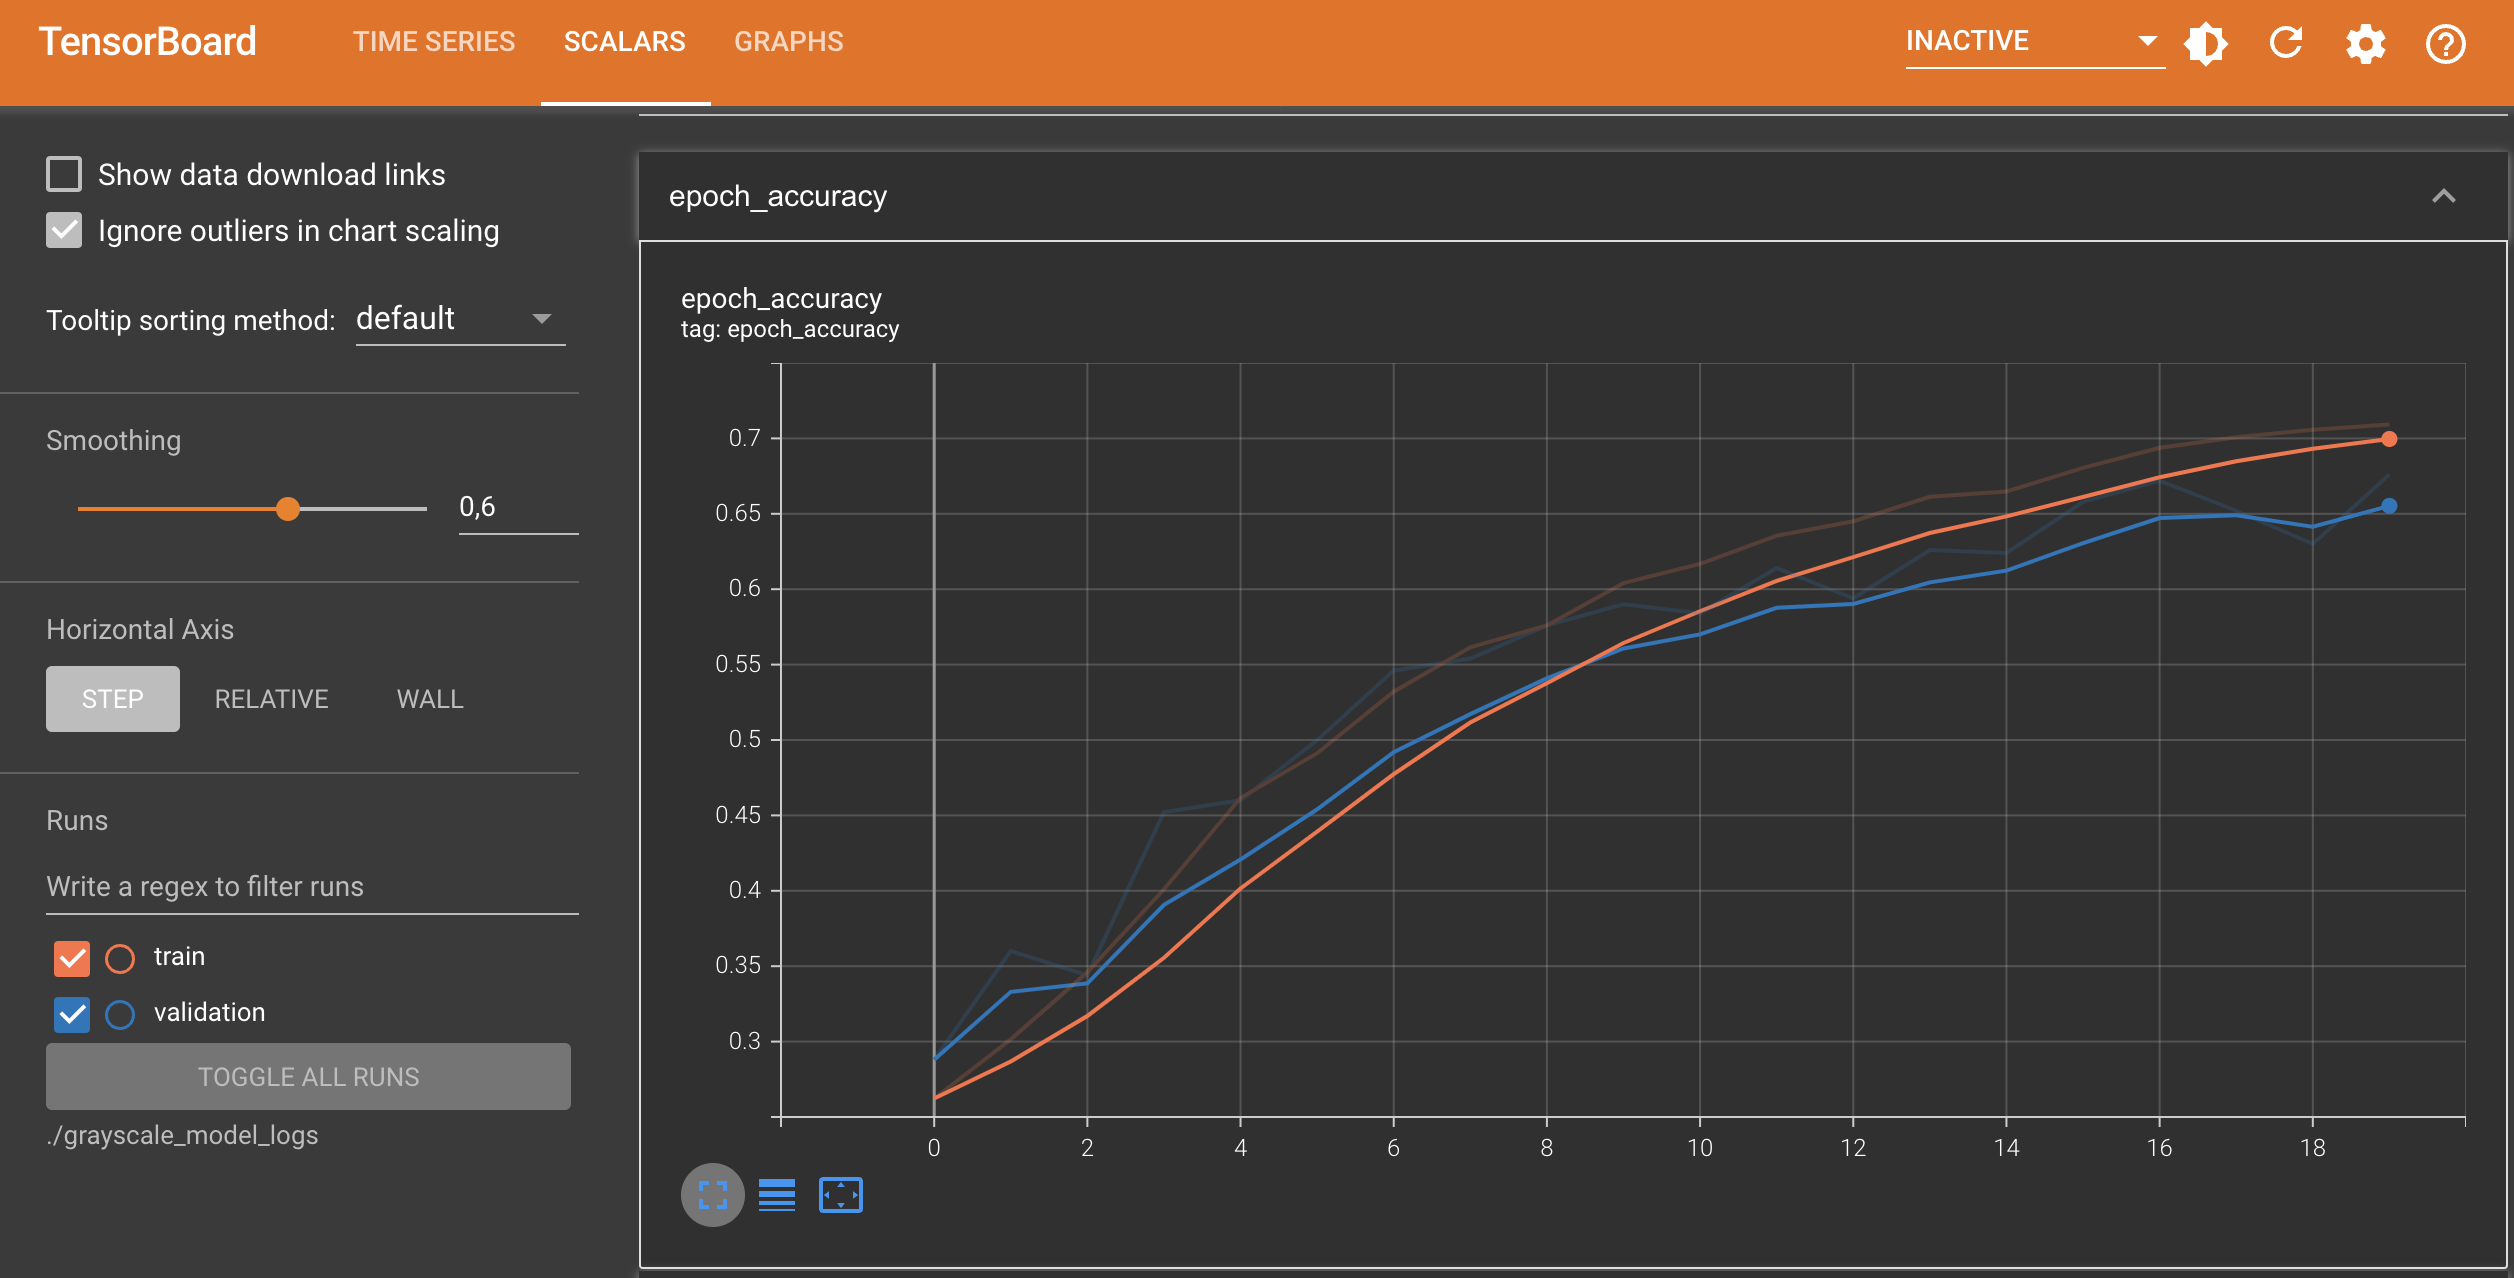

## Loss - epochs
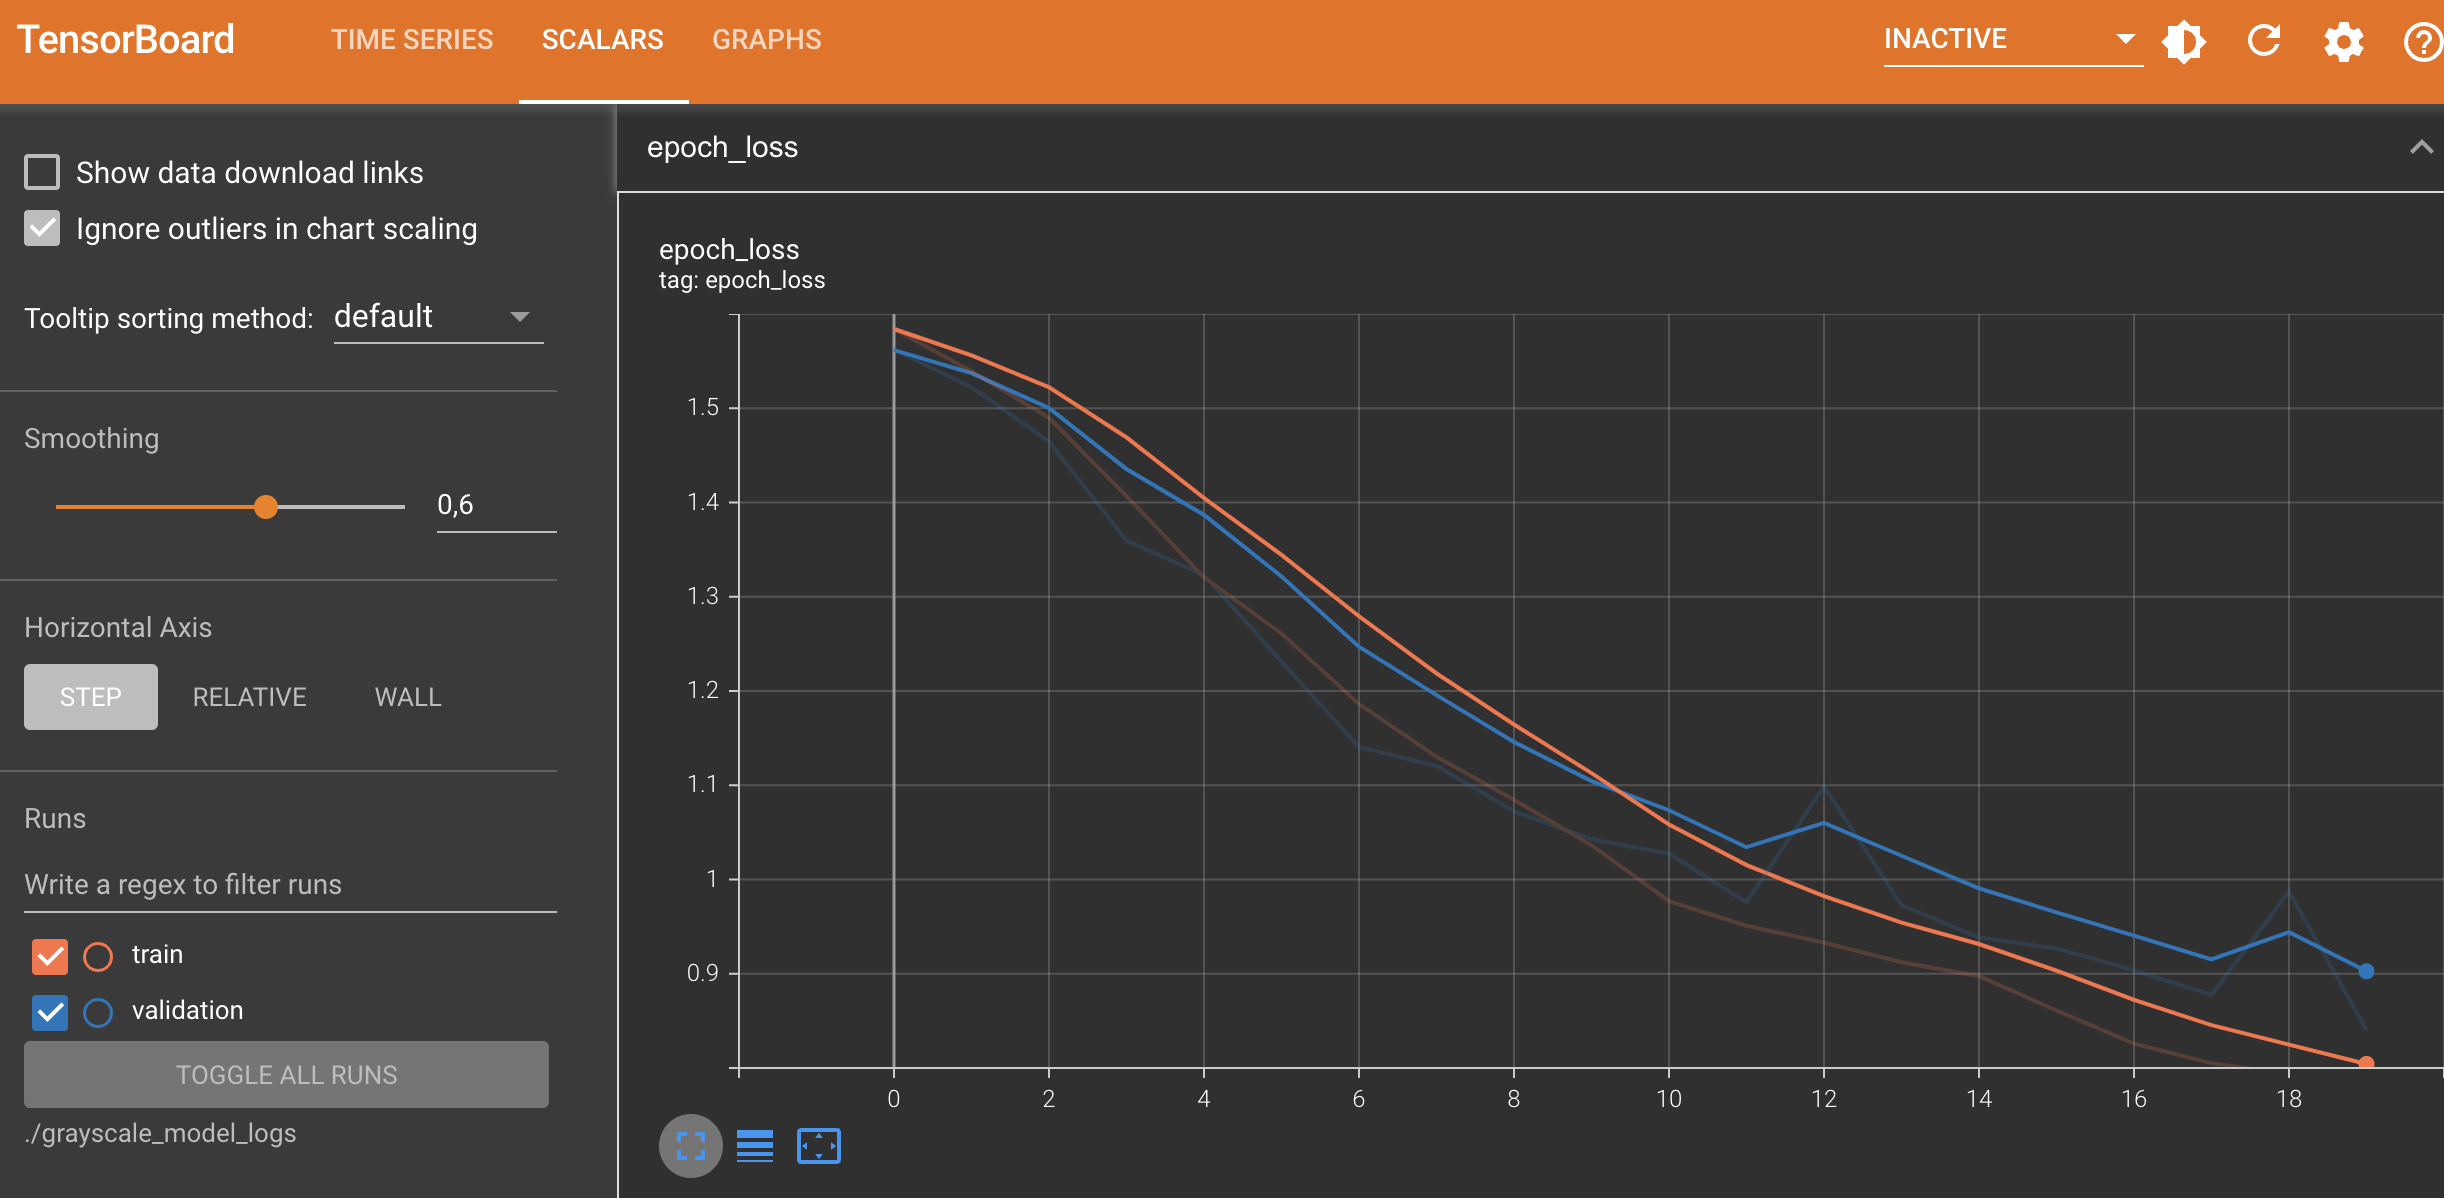

#### RGB images contain more information (color channels) that might be relevant for the task. Converting images to grayscale might lead to a loss of this information, potentially decreasing model performance. The impact depends on how much color information contributes to distinguishing between classes. In our cases some flowers have only one specific color, so color brings important information to our model. To get better result on grayscale images we must make more complex algorithm, so it can catch even small differences in flowers shapes.

## Evaluate Model with Metrics
#### mcld4 shows best result on validation set and through training process at all. Let's see how it performs on the test set.

In [35]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = mcld4_model.evaluate(train_generator_augmented_weak, steps= test_steps, verbose= 1)
valid_score = mcld4_model.evaluate(validation_generator, steps= test_steps, verbose= 1)
test_score = mcld4_model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 1s 53ms/step - loss: 0.7435 - accuracy: 0.7063
Train Loss:  0.7357065081596375
Train Accuracy:  0.699999988079071
--------------------
Valid Loss:  0.9006239175796509
Valid Accuracy:  0.65625
--------------------
Test Loss:  0.7435013651847839
Test Accuracy:  0.706250011920929


1/1 [==============================] - 0s 43ms/step


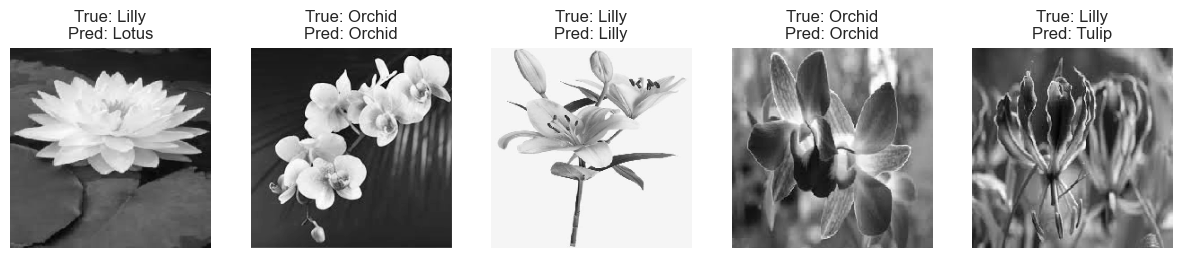

In [40]:
def show_predictions(model, test_generator, class_indices, num_images=5):
    class_labels = {v: k for k, v in class_indices.items()}
    
    test_images, test_labels = next(test_generator)
    
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i], cmap="gray")
        true_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()

show_predictions(mcld4_model, test_generator, test_generator.class_indices, num_images=5)


## Comparison with MLP
#### Given that our main model performs worse on grey scale, a simple MLP will show us even more unsatisfactory results compared to the rgb dataset.